In [1]:
using Pkg
Pkg.activate("SchrodingerEquationSolver")
include("SchrodingerEquationSolver.jl")

  Activating project at `~/Desktop/physics_coding_projects/julia/SchrodingerEquationSolver/src/SchrodingerEquationSolver`


Main.SchrodingerEquationSolver

In [2]:
import .SchrodingerEquationSolver as ses
import .ses.Grids as Grids
import .ses.Potentials as Potentials
import .ses.MathUtils as MathUtils
import .ses.Hydrogen as Hydrogen
import .ses.InitialConditions as InitialConditions
import .ses.OneDSchrodingerEquationSolver as odses
import .ses.OneDPoissonEquationSolver as odpes
import .ses.EigenvalueFinders as EigenvalueFinders
import .ses.AtomBasisSet as AtomBasisSet
import .ses.Density as Density
import .ses.ExchangeCorrelation as ExchangeCorrelation

In [3]:
using Plots

In [4]:
#r_min::Float64=0.0;
#r_max::Float64=50.0;
r_max::Float64=50.0;
Z::Int64=2;
#l::Int64=0;


2

In [5]:
#grid= Grids.uniform_grid(r_min, r_max, N);
grid= ses.Grids.exponential_grid(r_max, Z);
grid_sqrt= grid.^2.0;
N= size(grid)[1];

In [6]:

#init potentials
V_colu= Potentials.coulomb_potential(Z, grid);
V_hartree=zeros(Float64, N);
V_x=zeros(Float64, N);
V_c=zeros(Float64, N);
density_in= zeros(Float64, N);

In [7]:
basis= AtomBasisSet.init_atom_basis_set(Z, grid);

In [8]:


for i_orbi in basis.orbitals
    V_angu= Potentials.angular_potential(i_orbi.l, grid);
    V_effe= V_colu .+ V_angu 
    E_grid= Grids.uniform_grid(i_orbi.E - 0.2*i_orbi.E, i_orbi.E + 0.2*i_orbi.E, 150);

    E_intervals, bad_intervals= EigenvalueFinders.find_eigenvalue_intervals(E_grid, V_effe,
                                                    grid,InitialConditions.atom, i_orbi.l);
    
    u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(E_intervals[1], V_effe, grid,InitialConditions.atom);
    println(i_orbi.name)
    println("pred E", ei_temp)
    println("targ E", i_orbi.E)
    println("occupation ",i_orbi.occu)
    println("*****************")
    i_orbi.E=ei_temp
    i_orbi.u=u_temp


end

1s
pred E-2.0000017694849554
targ E-2.0
occupation 2.0
*****************


In [9]:
density_in= Density.calculate_density(basis);

In [10]:
C_in= MathUtils.integral((density_in.*grid_sqrt), grid)

2.0000000000000004

In [8]:
E_total=1.0
E_total_before=2.0;

while abs(E_total - E_total_before) > 10.0e-12
    E_eigen=0.0
    for i_orbi in basis.orbitals
        V_angu= Potentials.angular_potential(i_orbi.l, grid);
        V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;

        E_grid= Grids.uniform_grid(i_orbi.E - 0.2*i_orbi.E, i_orbi.E + 0.2*i_orbi.E, 150);

        E_intervals, bad_intervals= EigenvalueFinders.find_eigenvalue_intervals(E_grid, V_effe,
                                                        grid,InitialConditions.atom, i_orbi.l);
        println("E_intervals ", E_intervals)
        println("bad_intervals ", bad_intervals)
        u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(E_intervals[1], V_effe, grid,InitialConditions.atom);
        println(i_orbi.name)
        #println("pred E", ei_temp)
        #println("targ E", i_orbi.E)
        #println("occupation ",i_orbi.occu)
        #println("*****************")
        i_orbi.E=ei_temp
        i_orbi.u=u_temp
        E_eigen+= i_orbi.occu*ei_temp

    end

    E_total_before= float(E_total)
    density_out= Density.calculate_density(basis);
    density_in= Density.linear_mixing(density_in, density_out, alpha=0.25);
    V_hartree= odpes.solver(Z, density_in, grid);
    V_x, E_x, V_c, E_c= ExchangeCorrelation.potentials(density_in);

    V_xc= V_x .+ V_c;
    V_xc= MathUtils.integral((V_xc.*density_in.*grid_sqrt), grid)
    E_hartree= 0.5*(MathUtils.integral((V_hartree.*density_in.*grid_sqrt), grid))
    E_x= MathUtils.integral((E_x.*density_in.*grid_sqrt), grid)
    E_c= MathUtils.integral((E_c.*density_in.*grid_sqrt), grid)
    C_in= MathUtils.integral((density_in.*grid_sqrt), grid)
    C_out= MathUtils.integral((density_out.*grid_sqrt), grid)
    E_total= E_eigen - E_hartree + E_x + E_c - V_xc
    println("C_in ", C_in)
    println("C_out ", C_out)
    println("E_eigen ", (0.5*E_eigen))
    println("E_coul ", E_hartree)
    println("E_xc ", (E_x + E_c))
    println("V_xc ", V_xc)
    println("E_total ", E_total)
    println("*******************************")
end

E_intervals 

[(-1.9973154362416108, -2.002684563758389)]
bad_intervals Tuple{Float64, Float64}[]
1s


C_in 0.5000000000000001
C_out 2.0000000000000004
E_eigen -2.0000017694849554
E_coul 1.94208071034913
E_xc -0.42771078795260625
V_xc -0.5639328042792929
E_total -5.805862232992355
*******************************
E_intervals 

Tuple{Float64, Float64}[]
bad_intervals Tuple{Float64, Float64}[]


BoundsError: BoundsError: attempt to access 0-element Vector{Tuple{Float64, Float64}} at index [1]

In [24]:
function integral(func::Vector{Float64},grid::Vector{Float64})::Vector{Float64}
    I= 0.5.*(grid[2:end] .- grid[1:end-1]).*(func[2:end] .+ func[1:end-1])
    #I= sum(I)
    return I
end

integral (generic function with 1 method)

In [25]:
debb= integral(grid, density_in)

7357-element Vector{Float64}:
 -5.234777103083259e-15
 -1.4283312186174058e-14
 -2.160958863914401e-14
 -2.8561021601075614e-14
 -3.5372849500556645e-14
 -4.2097710132312434e-14
 -4.888250176551262e-14
 -5.568444345378332e-14
 -6.252639377249232e-14
 -6.940818839626906e-14
  ⋮
 -9.482613450343037e-83
 -6.0597913558813004e-83
 -3.868379505839238e-83
 -2.466824404699655e-83
 -1.5713493968103484e-83
 -9.997674590847608e-84
 -6.353673267281664e-84
 -4.032073530725269e-84
 -2.553842981846209e-84

In [11]:
temp_grid=grid[2:end] .- grid[1:end-1];

In [12]:
temp_func= density_in[2:end] .+ density_in[1:end-1];

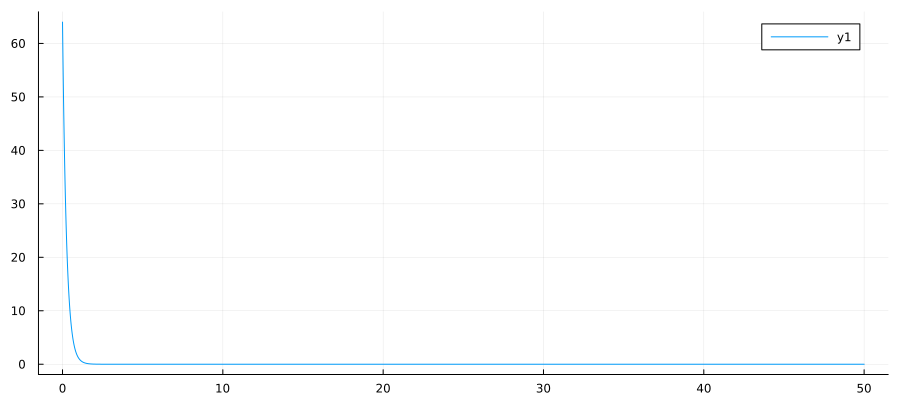

In [30]:
plot!(grid, [density_in])
plot!(size=(900,400))

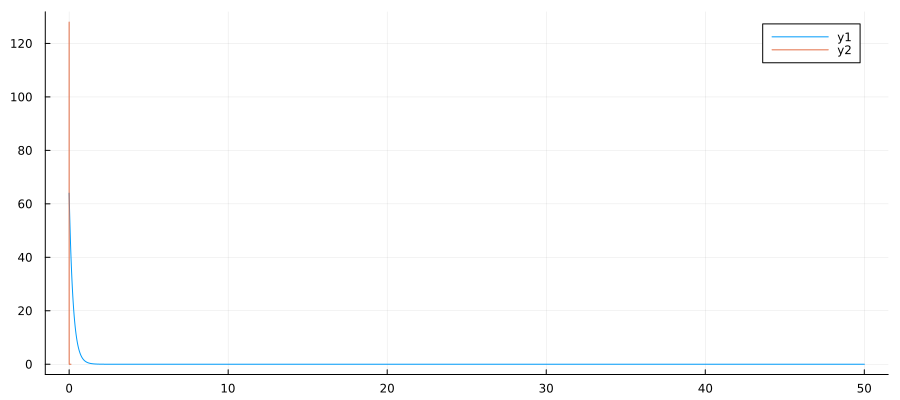

In [31]:
plot!(temp_grid, [temp_func])
plot!(size=(900,400))

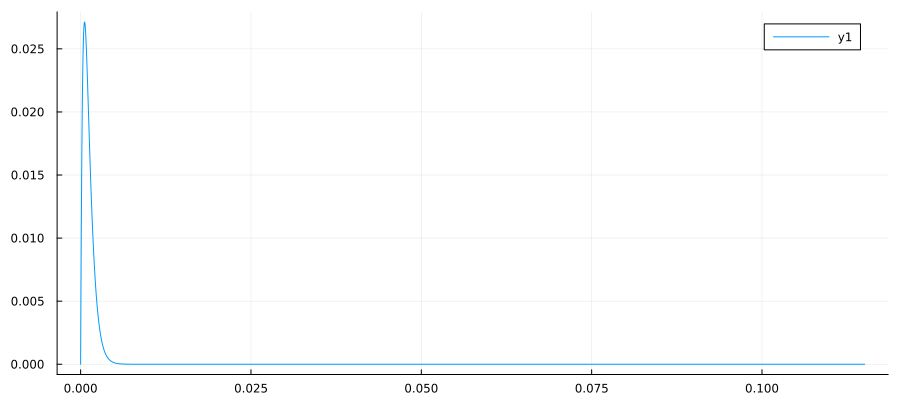

In [13]:
plot!(temp_grid, [temp_grid.*temp_func])
plot!(size=(900,400))

In [14]:
temp1=temp_grid.*temp_func;

In [21]:
eps(0.0)

5.0e-324

In [15]:
sum(temp1)

32.0000064378331

In [20]:
temp_func[end]

2.068706428247443e-85

In [10]:
C_in= MathUtils.integral(grid,(density_in.*grid_sqrt))

-2.0000000000000004

In [10]:
C_in= MathUtils.integral(grid,(4.0.*pi.*density_in.*grid_sqrt))

-2.000000000000001

In [11]:
density_out= Density.calculate_density(basis);
density_in= Density.linear_mixing(density_in, density_out, alpha=0.25);

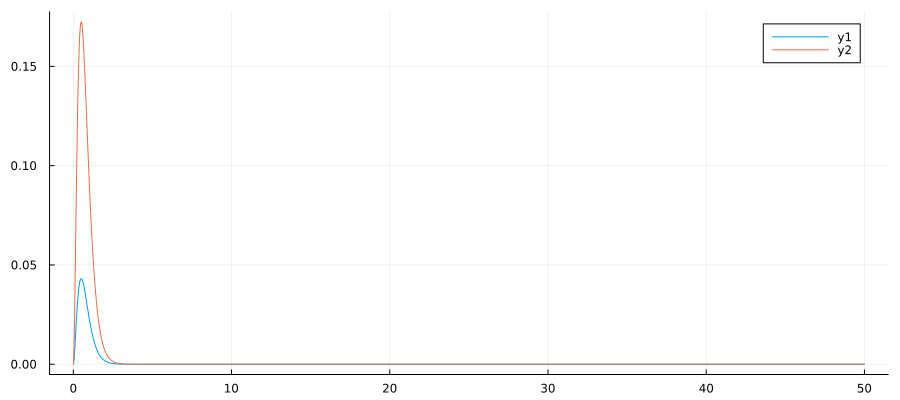

In [12]:
plot!(grid, [density_in.*grid.^2, density_out.*grid.^2])
plot!(size=(900,400))

In [13]:
C_in= MathUtils.integral(grid,(4.0.*pi.*density_in.*grid_sqrt))
C_out= MathUtils.integral(grid,(4.0.*pi.*density_out.*grid_sqrt))

-2.000000000000001

In [16]:
temp= grid[2:end] .- grid[1:end-1]

7357-element Vector{Float64}:
 5.016989896112653e-9
 5.028562367201145e-9
 5.040161532001217e-9
 5.051787452088711e-9
 5.06344018917633e-9
 5.075119805122755e-9
 5.0868263619288225e-9
 5.0985599217370246e-9
 5.110320546834399e-9
 5.1221082996510994e-9
 ⋮
 0.11296878861408999
 0.11322936877611767
 0.11349055000720654
 0.11375233369324889
 0.11401472122443579
 0.11427771399364417
 0.11454131339641549
 0.11480552083275342
 0.11507033770445929

In [18]:
minimum(temp)

5.016989896112653e-9

In [8]:
E_total=1.0
E_total_before=2.0;

while abs(E_total - E_total_before) > 10.0e-12
    E_eigen=0.0
    for i_orbi in basis.orbitals
        V_angu= Potentials.angular_potential(i_orbi.l, grid);
        V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;

        E_grid= Grids.uniform_grid(i_orbi.E - 0.2*i_orbi.E, i_orbi.E + 0.2*i_orbi.E, 150);

        E_intervals, bad_intervals= EigenvalueFinders.find_eigenvalue_intervals(E_grid, V_effe,
                                                        grid,InitialConditions.atom, i_orbi.l);
        
        u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(E_intervals[1], V_effe, grid,InitialConditions.atom);
        println(i_orbi.name)
        #println("pred E", ei_temp)
        #println("targ E", i_orbi.E)
        #println("occupation ",i_orbi.occu)
        #println("*****************")
        i_orbi.E=ei_temp
        i_orbi.u=u_temp
        E_eigen+= i_orbi.occu*ei_temp

    end

    E_total_before= float(E_total)
    density_out= Density.calculate_density(basis);
    density_in= Density.linear_mixing(density_in, density_out, alpha=0.25);
    V_hartree= odpes.solver(Z, density_in, grid);
    V_x, E_x, V_c, E_c= ExchangeCorrelation.potentials(density_in);

    V_xc= V_x .+ V_c;
    V_xc= 4.0*pi*(MathUtils.integral(grid, (V_xc.*density_in.*grid_sqrt)))
    E_hartree= 0.5*4.0*pi*(MathUtils.integral(grid, (V_hartree.*density_in.*grid_sqrt)))
    E_x= 4.0*pi*(MathUtils.integral(grid, (E_x.*density_in.*grid_sqrt)))
    E_c= 4.0*pi*(MathUtils.integral(grid, (E_c.*density_in.*grid_sqrt)))
    C_in= MathUtils.integral(grid,(4.0.*pi.*density_in.*grid_sqrt))
    C_out= MathUtils.integral(grid,(4.0.*pi.*density_out.*grid_sqrt))
    E_total= E_eigen + E_hartree - E_x - E_c + V_xc
    println("C_in ", C_in)
    println("C_out ", C_out)
    println("E_eigen ", (0.5*E_eigen))
    println("E_coul ", E_hartree)
    println("E_xc ", (E_x + E_c))
    println("V_xc ", V_xc)
    println("E_total ", E_total)
    println("*******************************")
end

1s


C_in 111078.62226531525
C_out -2.000000000000001
E_eigen -2.0000017694849554
E_coul -6.1671460510492865e6
E_xc -44813.20875782529
V_xc -58850.2986621058
E_total -6.181187140957106e6
*******************************


InexactError: InexactError: Int64(NaN)

In [9]:
u_orbitals=[i_orbi.u for i_orbi in basis.orbitals];

In [11]:
#plot!(grid, u_orbitals)
#plot!(size=(900,400))

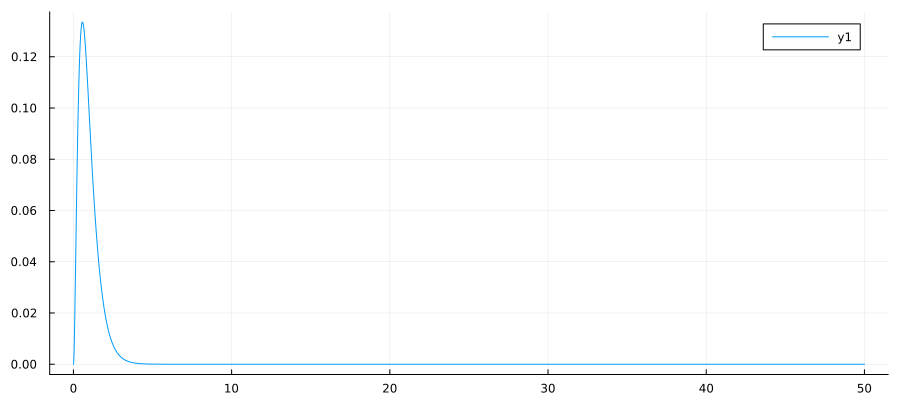

In [10]:

plot!(grid, (density_in.*grid.^2))
plot!(size=(900,400))


In [13]:
V_hartree= odpes.solver(Z, density, grid);
V_x, E_x, V_c, E_c= ExchangeCorrelation.potentials(density);


In [12]:
U_hartree_target=Hydrogen.U_hartree(grid);

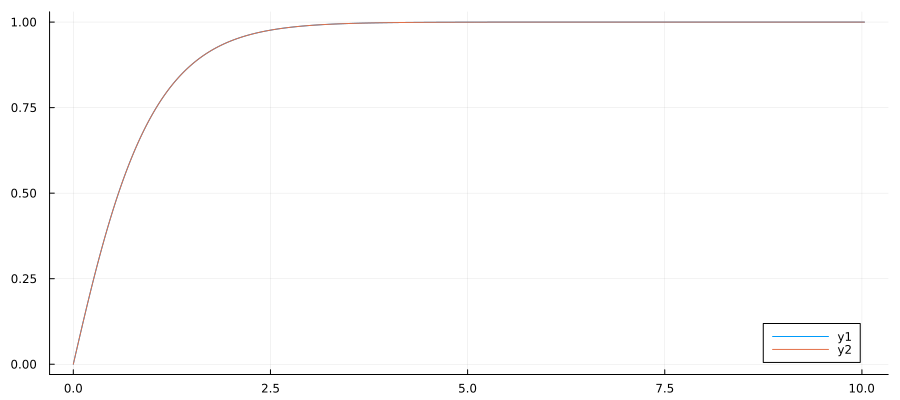

In [13]:
plot!(grid, [U_hartree,U_hartree_target])
plot!(size=(900,400))

In [15]:
error= MathUtils.error_difference(U_hartree,U_hartree_target)

9.434430007985173e-8